![](encabezado.png)

---

# Modelado e inversión 2D de gravimetría
---

In [67]:
import numpy as np
import matplotlib.pyplot as plt

import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics.gravimetry import GravityModelling2D

# Crear modelo sintético

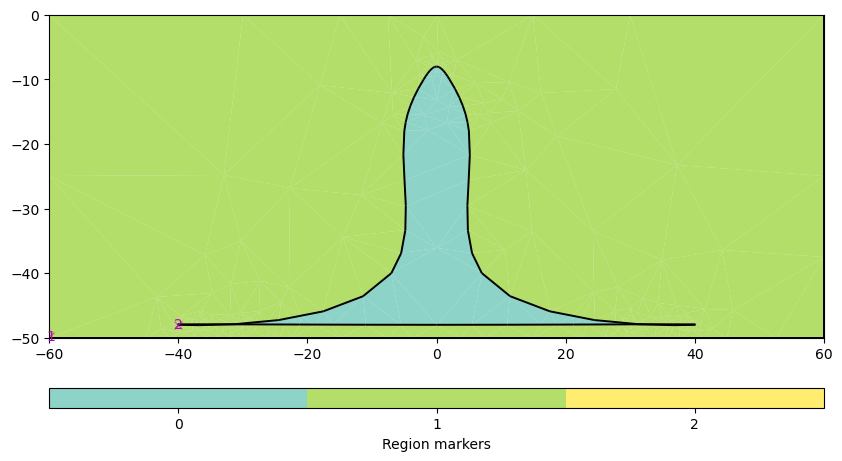

In [90]:
model = mt.createWorld(start=[-60,0], end=[60,-50], worldMarker=True)

# basement = mt.createPolygon(verts=[[0,-30],[0,-15],[20,-13],[40,-7],[70,-10],[80,-20],[90,-25],[100,-28],[100,-30]],
							# isClosed=True, marker=1)

dike = mt.createPolygon(verts=[[0,-30],[0,-20],[65,0],[95,0]], isClosed=True)
dike_trans = mt.createPolygon(verts=[[45,-20],[45,-10],[55,-10],[55,-20]], isClosed=True, marker=2)
# dike_trans.rotate([0,0,0])

salino = mt.createPolygon(verts=[[-40,-48],[-7,-40],[-5,-18],[-2,-10],[0,-8],
							   [2,-10],[5,-18],[7,-40],[40,-48],[0,-48]], isClosed=True, addNodes=5, interpolate='spline', marker=2)

# body = mt.createPolygon(verts=[[-50,-50], [-50,-20], [-30,-15], [-10,-10], [10,-20], [30,-30], [50,-20], [50,-50]], isClosed=True, marker=1)

# body = mt.createCircle(pos=[0,-30], radius=10, marker=2, nSegments=20)
geom = model + salino
pg.show(geom)
plt.gcf().set_size_inches(10,7)

## Generar malla

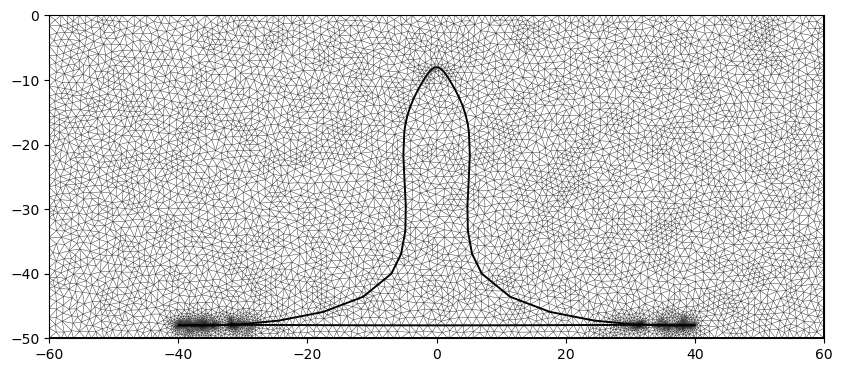

In [91]:

mesh = mt.createMesh(geom, quality=34, area=1)
# , smooth=[1,10]
pg.show(mesh)
plt.gcf().set_size_inches(10,7)


## Puntos de medición del gravímetro y mapeo de densidades en la malla

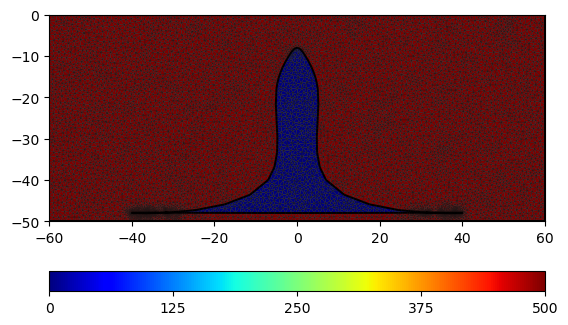

In [92]:
x = np.arange(-60,60,1.0)
pnts = np.array([x, np.zeros(len(x))]).T # Genera coordenadas (x,y) con y=0
density = [[1, 500],
		   [0, 0]]

drho = pg.solver.parseMapToCellArray(density, mesh) # Contraste de densidad para los diferentes medios
pg.show(mesh, data=density, showMesh=True, cMap='jet')
plt.show()

## Respuesta del modelo directo

In [93]:

fop = GravityModelling2D(mesh=mesh, points=pnts)
g = fop.response(drho)

## Se añade ruido

In [94]:
noise = 0.005
data = g + np.random.randn(len(g)) * noise

## Gráfica del modelo y la respuesta

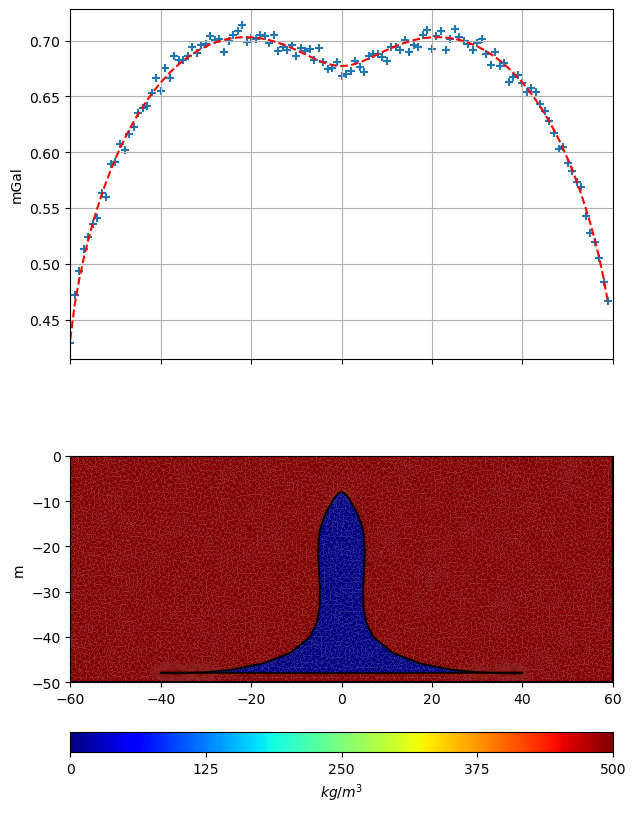

In [95]:
%matplotlib inline
fig, axes = plt.subplots(2,1, figsize=(7,10), sharex=True)
ax = axes[0]
ax.scatter(x, data, marker='+')
ax.plot(x, g, ls='--', c='r')
ax.set(ylabel='mGal')
ax.grid()

ax = axes[1]
_, cb= pg.show(mesh, drho, ax=ax, cMap='jet')
cb.set_label('$kg/m^3$')
# ax.plot(x, x*0, 'bv')
ax.set(ylabel='m')
plt.show()


# Inversión

## Se crea una nueva malla y modelo a partir del dominio rectangular

In [96]:
mesh2 = mt.createMesh(model, quality=34, area=1)
fop2 = GravityModelling2D(mesh=mesh2, points=pnts)

## Ponderación de profundidad

Se debe incluir una ponderación de profundidad, según el paper de Li & Oldenburg (1986) con la fórmula siguiente:

$$
w_{z} = \frac{1}{(z+z_{0})^{\beta/2}}
$$

Según Li & Oldenburg (1998), el factor $z_0$ depende del tamaño de celda de la discretización del modelo y de la altura de observación.

Este factor ayuda a estimar correctamente la profundidad de la anomalía al evitar que se concentre en la superficie

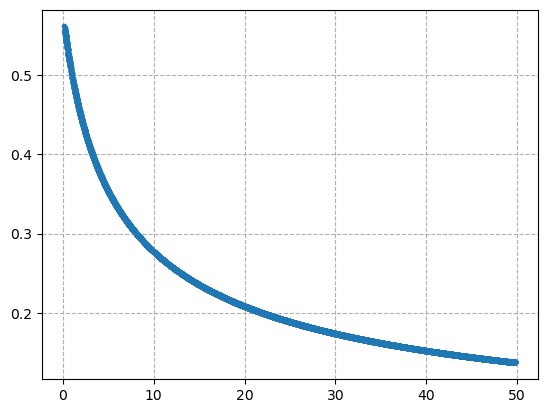

In [100]:
z = -pg.y(mesh2.cellCenters()) # todas las coordenadas y de la malla 2D (forma muy fancy de crear un vector de profundidad)
# the greater, the tighter the inversion
z0 = 3. # intentar con varios
beta = 1.
wz = 1/(z+z0)**(beta/2)
pg.show()[0].plot(z, wz, '.')
plt.grid(ls='--')
plt.show()

In [101]:
fop2.region(1).setConstraintType(2)
inv = pg.Inversion(fop=fop2)
inv.setRegularization(limits=[-2000,2000], trans='lin')
# , correlationLengths=[12,2]
inv.setConstraintWeights(wz)

rho = inv.run(data, absoluteError=noise, lam=1E2, verbose=True)

19/01/24 - 13:00:06 - pyGIMLi - INFO - Use median(data values)=0.6822481126782838
19/01/24 - 13:00:07 - pyGIMLi - INFO - Created startmodel from forward operator: 11811, min/max=0.682248/0.682248
19/01/24 - 13:00:07 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.gravimetry.gravMagModelling.GravityModelling2D object at 0x0000020308AD5BD0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000020360799E80>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTrans object at 0x00000203158B7A00>
min/max (data): 0.43/0.71
min/max (error): 0.7%/1.17%
min/max (start model): 0.68/0.68
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 17209.20
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =  458.27 (dPhi = 85.52%) lam: 100.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =  458.05 (dPhi = 56.37%) lam: 100.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =  407.43 (dPhi = 28.14%) lam: 100.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =  377.96 (dPhi =

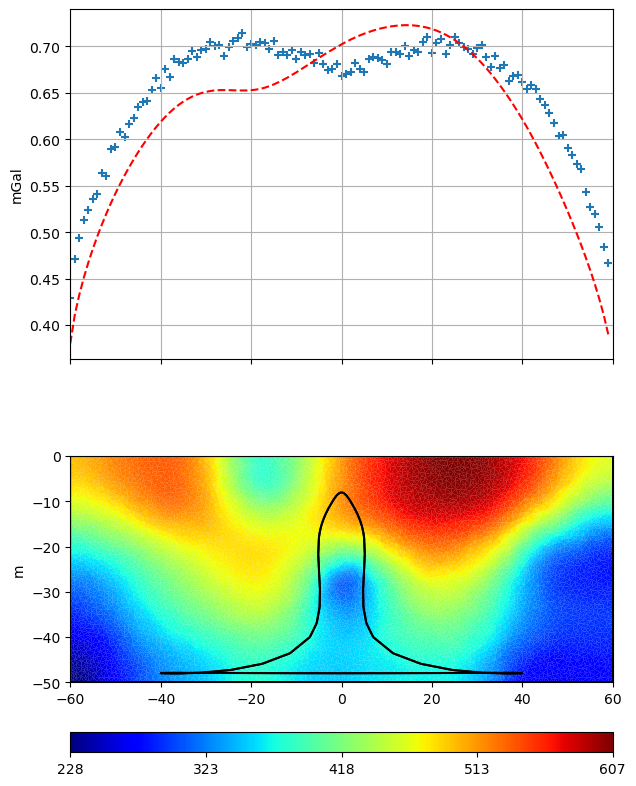

In [102]:
fig, axes = plt.subplots(2,1, figsize=(7,10), sharex=True)
ax = axes[0]
ax.scatter(x, data, marker='+')
ax.plot(x, inv.response, ls='--', c='r')
ax.set(ylabel='mGal')
ax.grid()

ax = axes[1]
pg.show(mesh2, rho, ax=ax, logScale=False, cMap='jet')
pg.show(geom, fillRegion=False, regionMarker=False, ax=ax)
# ax.plot(x, x*0, 'bv')
ax.set(ylabel='m')
plt.show()
